In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45
from scipy.integrate import RK23

# initial conditions

In [3]:
# Water hammer
L=20         # 管线长度
Hr=100          # 泵压力
D=797/1000
Rho=1000	    # 液体密度kg/m^3
g=9.81        # 重力加速度
f=0.02
#f=0.018        # 摩擦系数
A=np.pi*D*D/4     # 管道横截面积
#a=np.sqrt(K/Rho/(1+K*D/E*e)) # 波速
a=1025.7

In [4]:
# Parameters
N = 400 # Number of particles
mass_value = A*L/N # Mass of the particles
kappa = 2 # Used in the NNPS algorithm
nu = 1.4 # Scaling factor for the smoothing factor 光滑长度比例

In [25]:
mass = np.zeros(3*N) + mass_value
mass.shape

(1200,)

In [6]:
# Give the particles evenly spaced positions before and after the wall
x = np.zeros(N)
x[:] = np.linspace(0,L,N,endpoint=False)

In [7]:
# Initial density for the particles
rho = np.zeros(N)+Rho

In [8]:
# Initial velocities are the same, set at 0
v0=0.1
v = np.zeros(N)+v0

In [9]:
# Initial pressures-
p = np.zeros(N)
p=Hr-x*f*v0*v0/(L*2*D)

In [10]:
Sf=f*v*np.abs(v)/(2*D)
Sf.shape

(400,)

In [11]:
# Create the initial state vector as a matrix
W0 = np.zeros((N, 5)) # Change to W0.
W0[:,0] = x
W0[:,1] = rho
W0[:,2] = v
W0[:,3] = p
W0[:,4] = Sf
NParams = len(W0[1])
W0

array([[0.00000000e+00, 1.00000000e+03, 1.00000000e-01, 1.00000000e+02,
        1.25470514e-04],
       [5.00000000e-02, 1.00000000e+03, 1.00000000e-01, 9.99999997e+01,
        1.25470514e-04],
       [1.00000000e-01, 1.00000000e+03, 1.00000000e-01, 9.99999994e+01,
        1.25470514e-04],
       ...,
       [1.98500000e+01, 1.00000000e+03, 1.00000000e-01, 9.99998755e+01,
        1.25470514e-04],
       [1.99000000e+01, 1.00000000e+03, 1.00000000e-01, 9.99998752e+01,
        1.25470514e-04],
       [1.99500000e+01, 1.00000000e+03, 1.00000000e-01, 9.99998748e+01,
        1.25470514e-04]])

In [12]:
def reservoir(W):
    # 传入Wleft
    N=W.shape[0]
    Wleft=np.zeros_like(W)
    Wleft[:,0] = W[:,0]
    Wleft[:,1] = W[:,1]
    Wleft[:,2] = W[N-1,2] # 等于第一颗粒子的速度
    Wleft[:,3] = Hr # 压力恒定
    Wleft[:,4] = W[:,4]
    return Wleft

In [46]:
def valve(W0,W1):
    # 传入W0=Wmiddle，W1=Wright
    N=W0.shape[0]
    Wright=np.zeros_like(W0)
    Wright[:,0] = W1[:,0]
    Wright[:,1] = W1[:,1]
    # for i in range(N): #mirror
    #     Wright[i,2] = -W0[N-i-1,2]
    #     Wright[i,3] = W0[N-i-1,3]
    Wright[:,2] = 0
    Wright[:,3] = W1[:,3]
    Wright[:,4] = W1[:,4]
    return Wright

In [14]:
Wleft = W0.copy() # Change to W0.
Wleft[:,0] = x-L
Wright = W0.copy() # Change to W0.
Wright[:,0] = x+L

In [15]:
# Reshape matrix into a vector
W = np.row_stack([Wleft,W0,Wright])
W

array([[-2.00000000e+01,  1.00000000e+03,  1.00000000e-01,
         1.00000000e+02,  1.25470514e-04],
       [-1.99500000e+01,  1.00000000e+03,  1.00000000e-01,
         9.99999997e+01,  1.25470514e-04],
       [-1.99000000e+01,  1.00000000e+03,  1.00000000e-01,
         9.99999994e+01,  1.25470514e-04],
       ...,
       [ 3.98500000e+01,  1.00000000e+03,  1.00000000e-01,
         9.99998755e+01,  1.25470514e-04],
       [ 3.99000000e+01,  1.00000000e+03,  1.00000000e-01,
         9.99998752e+01,  1.25470514e-04],
       [ 3.99500000e+01,  1.00000000e+03,  1.00000000e-01,
         9.99998748e+01,  1.25470514e-04]])

# SPH function

In [26]:
def h_len(mass, density):
    """ Calculates the smoothing length for all the particles for a given
    state vector. """
    return np.zeros(3*N) + nu*(mass/density)

def smoothingW(dx, h):
    """ Utilizes the relative distances of a pair to calculate the
    smoothing function. The input relative distanc has already been calculated
    with the smoothing factor h."""

    ad = (1/h) # Alpha-d factor
    R = np.linalg.norm(dx)/h

    if R >= 0 and R < 1:
        smoothW = ad*(2/3 - R**2 + 0.5*R**3)

    elif R >=1 and R < 2:
        smoothW = ad*(((2-R)**3)/6)

    else:
        smoothW = 0.0

    return smoothW

def smoothingdW(dx, h):
    """ Utilizes the relative distances of a pair to calculate the
    derivative of the smoothing function. The input relative distanc has
    already been calculated with the smoothing factor h."""

    ad = (1/h) # Alpha-d factor
    R = np.linalg.norm(dx)/h

    if R >= 0 and R < 1:
        smoothdW = ad*(-2 + (3/2)*R)*(dx/h**2)

    elif R >=1 and R < 2:
        smoothdW = -ad*(0.5*((2-R)**2))*(dx/(h*abs(dx)))

    else:
        smoothdW = 0.0

    return smoothdW

def artificialv(x1, x2, rho1, rho2, v1, v2, p1, p2, h1, h2):
    """ Calculates the artificial viscosity for a pair. """

    # Define parameters that go into the artificial viscosity
    #c1 = np.sqrt(g*p1)
    #c2 = np.sqrt(g*p2)
    c1=a
    c2=a
    alpha = 1
    beta = 1
    eta = 0.1 # theta=eta^2 (origin paper theta=0.01 =>  eta=0.1)

    # Relative quantities
    dx = x1 - x2
    dv = v1 - v2
    c_rel = (c1 + c2)/2
    rho_rel = (rho1 + rho2)/2
    h_pair = (h1 + h2)/2
    theta = eta*h_pair
    phi_rel = (h_pair*np.dot(dv, dx))/(np.linalg.norm(dx)**2 + theta**2)

    # Calculate viscosity
    visc = 0
    if np.dot(dv, dx) < 0:
        visc = (-alpha*c_rel*phi_rel + beta*phi_rel**2)/rho_rel

    else:
        visc = 0

    return visc

# PDE derivation

In [17]:
def pressure(mass, density1, density2,vel1, vel2, smoothingdW):
    return -a*a*mass*(vel1-vel2)*smoothingdW

def velocity(mass, density1, density2, pressure1, pressure2, smoothingdW, artvisc):
    """ Calculates the derivative of density for a given pair of particles. """
    return -mass*(pressure1/density1**2 - pressure2/density2**2 + artvisc)*smoothingdW

# MAIN interate

In [53]:
# Nearest neighbor search loop:
def integrate(WTMP):
    #W = W.reshape(3*N, NParams) # Reshape vector into matrix.
    WWTMP = WTMP[np.argsort(WTMP[:,0])] # 按距离排序
    Wleft=reservoir(WTMP[:N,:])
    W0=WTMP[N:2*N,:]
    Wright=valve(WTMP[N:2*N,:],WTMP[2*N:,:])
    W=np.row_stack([Wleft,W0,Wright])
    #print(W.shape)

    # Initialize NNPS algorithm - create empty list for storing the results
    pair_i = []
    pair_j = []
    smoothW = []
    smoothdW = []
    #print(mass/W[:,1])
    h = h_len(mass, W[:,1]) #np.zeros(len(W)) + 0.0075 # Updated smoothing lengths for each integrated W

    dx_s = []

    for i in range(N - 1):
        for j in range(i+1, N): # 只看右边粒子？
            dx = (W[i,0] - W[j,0])
            h_pair = (h[i] + h[j])/2 # 取光滑核长度均值
            if np.linalg.norm(dx) <= kappa*h_pair:
                # Store indexes
                pair_i.append(i) # 放索引
                pair_j.append(j)

                # Calculate smoothing functions for the pair
                smoothW.append(smoothingW(dx, h_pair)) # 计算W
                smoothdW.append(smoothingdW(dx, h_pair)) # 计算grad W

                dx_s.append(dx) # 放距离差

    npairs = len(pair_i) # Define number of pairs in the given loop

    # Calculate density using the summation density
    W[:,1] = mass*(2/(3*h)) # Density self effect (for every particle) # 这个1.5有点迷
    dW = np.zeros(np.shape(W)) # Empty array to store the derivatives # answer

    for k in range(npairs):
        pi = pair_i[k]
        pj = pair_j[k]

        W[pi,1] += mass[pj]*smoothW[k] # 更新密度
        W[pj,1] += mass[pi]*smoothW[k]

    W[:,4]  = f*W[:,2]*np.abs(W[:,2])/(2*D) # Updates pressure. Depends only on particle # 由密度和能量更新压力

    # update 3 segments


    # Compute the derivatives
    for k in range(npairs):
        #W[:,0] = x
        #W[:,1] = rho
        #W[:,2] = v
        #W[:,3] = e
        #W[:,4] = p

        # Get index for each particle of the pair
        pi = pair_i[k]
        pj = pair_j[k]

        # Calculate artificial viscosity for each pair
        #artificialv(dx, rho1, rho2, v1, v2, energy1, energy2, h1, h2):
        artvisc = artificialv(W[pi,0], W[pj,0], W[pi,1], W[pj,1],
                              W[pi,2], W[pj,2], W[pi,3], W[pj,3], h[pi], h[pj])

        # Compute (derivatives of) velocities for each particle from the pair
        dW[pi,2] += velocity(mass[pj], W[pi,1], W[pj,1], W[pi,3], W[pj,3], smoothdW[k], artvisc)
        dW[pj,2] -= velocity(mass[pi], W[pj,1], W[pi,1], W[pj,3], W[pi,3], smoothdW[k], artvisc)

        # Derivatives of the internal energy
        dW[pi,3] += pressure(mass[pj], W[pi,1], W[pj,1], W[pi,2], W[pj,2], smoothdW[k])
        dW[pj,3] -= pressure(mass[pi], W[pi,1], W[pj,1],W[pj,2], W[pi,2], smoothdW[k])

    # Derivatives of density and pressure are 0
    dW[:,1] = 0 # 密度不变，梯度为0
    dW[:,2] = dW[:,2]-W[:,4]
    dW[:,4] = 0 # 压力仅与能量、密度有关，梯度为0
    dW[:,0] = W[:,2] # Derivative of the position is the input velocity


    #dW = dW.reshape(N*NParams)

    return dW

# Interation: time calculation

In [47]:
# Integration parameters
tstep = 5e-3
tmin = 0
tmax = 0.1
steps = np.arange(tstep, tmax, tstep)
NSteps = len(steps)
NSteps

19

In [48]:
W_i = np.zeros([NSteps, 3*N, NParams])
W_i[0]=W
W_i[0].shape

(1200, 5)

In [54]:
import time
time_begin=time.time()
# Loop for the integration
for i in range(1,NSteps):
    W_d=integrate(W_i[i-1])
    W_i[i]=W_i[i-1]+tstep*W_d
    print(i)

time_end=time.time()
print("Running time:",time_end-time_begin)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
Running time: 4.13494873046875


# plot

In [55]:
# Define the state vector for the last integrated timestep.
W_plot = W_i[NSteps-1]
W_plot[N:N*2,:]

array([[8.99952011e-03, 1.00000000e+03, 9.99887089e-02, 1.00000000e+02,
        1.25470514e-04],
       [5.89995201e-02, 1.00000000e+03, 9.99887089e-02, 9.99999997e+01,
        1.25470514e-04],
       [1.08999520e-01, 1.00000000e+03, 9.99887089e-02, 9.99999994e+01,
        1.25470514e-04],
       ...,
       [1.98589995e+01, 1.00000000e+03, 9.99887089e-02, 9.99998755e+01,
        1.25470514e-04],
       [1.99089995e+01, 1.00000000e+03, 9.99887089e-02, 9.99998752e+01,
        1.25470514e-04],
       [1.99589995e+01, 1.00000000e+03, 9.99887089e-02, 9.99998748e+01,
        1.25470514e-04]])

Text(0, 0.5, '$Internal energy \\, \\, [J/kg]$')

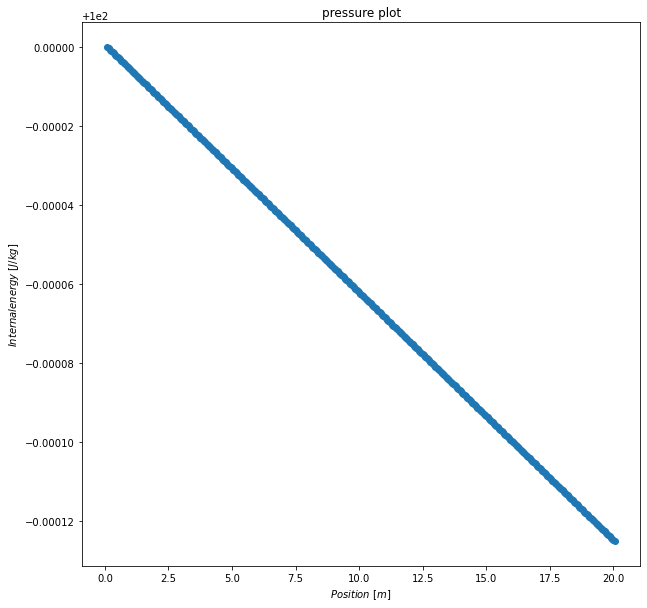

In [44]:
# Plot energies
plt.figure(figsize=[10,10])
plt.scatter(W_plot[N:N*2,0], W_plot[N:N*2,3])
plt.title('pressure plot')
plt.xlabel('$Position \, \,[m]$')
plt.ylabel('$Internal energy \, \, [J/kg]$')